# Train Model on Brownian Motion PDE using KL divergence

## Setup

### Import Necessary Packages

In [1]:
import torch
import numpy as np
import wandb

from neuralop.models import FNO
from neuralop.losses import LpLoss
from neuralop import Trainer
from matplotlib import pyplot as plt

## Dataset

In [2]:
class BrownianMotionDataset(torch.utils.data.Dataset):
    def __init__(self,
                 N: int,
                 B: int=100, 
                 N_x: int=128,
                 X: tuple[float, float]=(0.0,1.0), 
                 T: float=1.0, 
                 D_range: tuple[float, float]=(1.0, 1.0), 
                 initial_condition: callable=None, 
                 transform: callable=None, 
                 as_prob: bool=False,
                 include_D: bool=False,
                 channels_first: bool=False,
                 seed: int=None, 
                 device: str | torch.device=None):
        """
        Dataset for 1D diffusion (Brownian motion) using closed‐form solution.

        Args:
            N: number of initial conditions (dataset size)
            B: number of time steps per trajectory
            N_x: number of spatial grid points
            X: The spatial domain
            T: total simulation time
            D_range: (min_D, max_D), sampled per sequence
            include_D: whether to include D as part of the input features
            channels_first: Whether to return (B, C, N_X) or (B, N_X, C)
            return_grid: Whether or not to return the mesh grid
            as_prob: whether or not to normalize u(x,t) to sum to 1 (ie interpret u(x, t) as a probability distribution)
            seed: base random seed for reproducibility
            transform: optional callable (u_in, u_out) -> (u_in_aug, u_out_aug)
            initial_condition: optional function x->u0(x); if provided, it is used for the IC
            device: torch device
        """
        super().__init__()
        self.N = N
        self.B = B
        self.N_x = N_x
        self.L = X[1] - X[0]
        self.X = X
        self.T = T
        self.D_range = D_range
        self.channels_first = channels_first
        self.as_prob = as_prob
        self.include_D = include_D
        self.seed = seed
        self.transform = transform
        self.initial_condition = initial_condition

        if isinstance(device, str):
            self.device = torch.device(device)
        elif device is None:
            self.device = torch.device("cpu")
        else: 
            self.device = device

        # Precompute the spatial and temporal grids.
        # Note: when using an IC function, we perform a convolution over spatial grid,
        # so we only need the 1D grid and a time vector.
        self.x = torch.linspace(X[0], X[1], N_x, device=self.device)  # shape: [N_x]
        self.dx = (self.L/(N_x-1))
        self.t = torch.linspace(0, T, B, device=self.device)      # shape: [B]
        # For the closed-form branch we also need a meshgrid; we create it later on
        # in the else branch.
        self.x_grid, self.t_grid = torch.meshgrid(self.x, self.t, indexing='ij')  # shapes: [N_x, B]
        self.xt_grid = torch.stack([self.x_grid, self.t_grid], axis=-1)
        if self.channels_first:
            self.xt_grid = self.xt_grid.permute(2,0,1)

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        gen = torch.Generator(device=self.device)
        if self.seed is not None:
            gen.manual_seed(self.seed + idx)

        # Sample diffusion coefficient D for this trajectory
        D = torch.rand(1, generator=gen, device=self.device) * (self.D_range[1] - self.D_range[0]) + self.D_range[0]
        eps = 1e-8

        if self.initial_condition is not None:
            # Use the provided IC: u0 = initial_condition(x), shape [N_x]
            u0 = self.initial_condition(self.x)  # [N_x]
            u0 = u0 / u0.sum()
            dx = self.L / (self.N_x - 1)

            # The closed-form solution for diffusion with an arbitrary IC is
            #    u(x,t)=∫ K(x,x',t) u0(x') dx',
            # with the kernel
            #    K(x,x',t)= exp[-(x-x')^2/(4Dt)] / sqrt(4πDt).
            # We build a kernel for all time steps simultaneously.
            # Set up two copies of x for broadcasting:
            x_out = self.x.unsqueeze(1)  # shape: [N_x, 1]
            x_in  = self.x.unsqueeze(0)  # shape: [1, N_x]
            diff = x_out - x_in          # shape: [N_x, N_x]
            # Now set up a time vector for each time step.
            # t_exp: shape [1, 1, B]
            t_exp = self.t.unsqueeze(0).unsqueeze(0)
            # Now compute the kernel for all t:
            # kernel will have shape [N_x, N_x, B]
            kernel = torch.exp(- diff.unsqueeze(2)**2 / (4 * D * t_exp + eps)) / \
                     torch.sqrt(4 * torch.pi * D * t_exp + eps)
            # Now perform the convolution (sum over the integration variable x'):
            # u(x,t) = sum_{x'} kernel(x, x', t) * u0(x') * dx.
            u = torch.einsum('ijn,j->in', kernel, u0) * dx  # shape: [N_x, B]
            u = u.T.contiguous()  # reshape to [B, N_x]
            u[0] = u0
        else:
            # no initial_condition is provided: use random Gaussian parameters.
            x0 = torch.rand(1, generator=gen, device=self.device) * 0.5 + 0.25
            sigma = torch.rand(1, generator=gen, device=self.device) * 0.15 + 0.05
            # Here, we already have self.x_grid (shape: [N_x, B]) and self.t_grid (shape: [N_x, B])
            sigma_t = sigma**2 + 2 * D * self.t_grid  # shape: [N_x, B]
            u = 1. / torch.sqrt(2 * torch.pi * sigma_t) * torch.exp(
                - (self.x_grid - x0)**2 / (2 * sigma_t)
            )  # shape: [N_x, B]
            u = u.T.contiguous()  # shape: [B, N_x]

        # Now we create our trajectory pairs.
        # u has shape [B, N_x]; we want to predict u(t+1) from u(t):
        u_in = u[:-1].unsqueeze(-1)   # shape: [B-1, N_x, 1]
        u_out = u[1:].unsqueeze(-1)     # shape: [B-1, N_x, 1]

        # Apply any augmentations to the solution, if provided.
        if self.transform:
            u_in, u_out = self.transform(u_in, u_out)

        if self.as_prob:
            u_in = u_in / (u_in.sum(dim=1, keepdim=True) + 1e-8)  # Normalize by sum to 1
            u_out = u_out / (u_out.sum(dim=1, keepdim=True) + 1e-8)

        # Finally, if include_D is True, append D as an extra channel to u_in.
        if self.include_D:
            # D is a scalar here; expand it to match [B-1, N_x, 1] (unchanged in time and space)
            D_feat = D.expand(u_in.shape[0], u_in.shape[1], 1)
            u_in = torch.cat([u_in, D_feat], dim=-1)  # shape becomes [B-1, N_x, 2]

        if self.channels_first:
            u_in = u_in.permute(0,2,1)
            u_out = u_out.permute(0,2,1)

        return {"x":u_in.to(self.device), "y": u_out.to(self.device)}


## Helper Classes

### Augmentations

In [3]:
class AddGaussianNoise:
    def __init__(self, std=0.01):
        self.std = std

    def __call__(self, u_in, u_out):
        noise = torch.randn_like(u_in) * self.std
        return u_in + noise, u_out

In [4]:
class KLDivergence:
    def __init__(self, *args, **kwargs):
        self.kl = torch.nn.KLDivLoss(*args, **kwargs)

    def __call__(self, y_pred: torch.Tensor, y: torch.Tensor, **kwargs):
        return self.forward(y_pred, y, **kwargs)

    def forward(self, y_pred: torch.Tensor, y: torch.Tensor, **kwargs):
        assert y_pred.shape == y.shape, (y.shape, y_pred.shape)

        y_pred = torch.nn.functional.log_softmax(y_pred, dim=-1)

        return self.kl(y_pred, y)

### Initial Conditions

In [5]:
def center_peak_ic(x, amplitude=1.0, width=0.1):
    """
    Generates an initial condition with a Gaussian peak centered in the middle of the domain.
    
    Parameters:
    - x (torch.Tensor): The spatial grid, a 1D tensor representing spatial points.
    - amplitude (float): The peak value at the center (default: 1.0).
    - width (float): The width of the peak. Controls how quickly the value decays away from the center (default: 0.1).
    
    Returns:
    - torch.Tensor: The initial condition profile with a peak at the center of the domain.
    """
    
    # Calculate the distance from the center (center is x[len(x) // 2])
    distance = torch.abs(x - x[len(x) // 2])
    
    # Define the Gaussian profile
    profile = torch.exp(-distance**2 / (2 * width**2))
    
    # Scale by the amplitude to set the peak value at the center
    return amplitude * profile

In [6]:
def delta_ic_gaussian(x_grid, center=0.5, sigma=0.05):
    """
    Approximates a Dirac delta centered at `center` using a narrow Gaussian.
    
    Args:
        x_grid (torch.Tensor): (N_x,) spatial grid
        center (float): location of the spike (default 0.5)
        sigma (float): width of the Gaussian (default 0.01)
    
    Returns:
        u0 (torch.Tensor): (N_x,) normalized initial condition
    """
    u0 = torch.exp(-0.5 * ((x_grid - center) / sigma) ** 2)
    u0 = u0 / (u0.sum() * (x_grid[1] - x_grid[0]))  # normalize to integrate to 1
    return u0

In [7]:
def no_batching_fn(data):
    return data[0]

## Visualize Data

### Instantiate Data

In [8]:
ds = BrownianMotionDataset(
    N=1000, include_D=False, seed=42,
    initial_condition=None, as_prob=True
)

### Check single input shapes

In [9]:
data_dict = ds[1]
u_t = data_dict["x"]; u_t_1 = data_dict["y"]
u_t.shape, u_t_1.shape

(torch.Size([99, 128, 1]), torch.Size([99, 128, 1]))

### Visualize data

Text(0.02, 0.5, 'x')

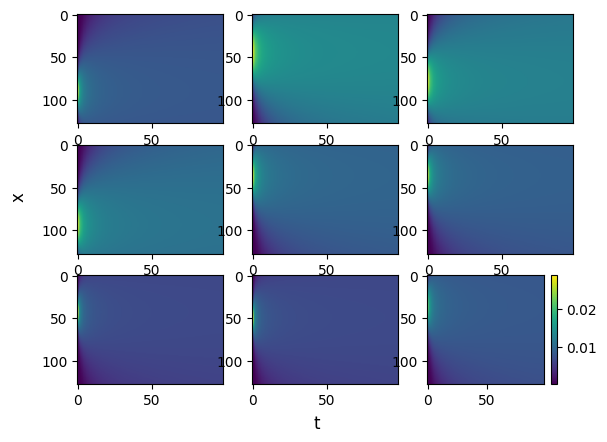

In [10]:
fig, axs = plt.subplots(3,3)
k=0
for i in range(3):
    for j in range(3):
        data_dict = ds[k]
        traj_t = data_dict["x"]
        #print(traj_t.sum(axis=1))
        im = axs[i,j].imshow(traj_t.squeeze().T, aspect="auto")
        k+=1
fig.colorbar(im)
fig.supxlabel("t")
fig.supylabel("x")

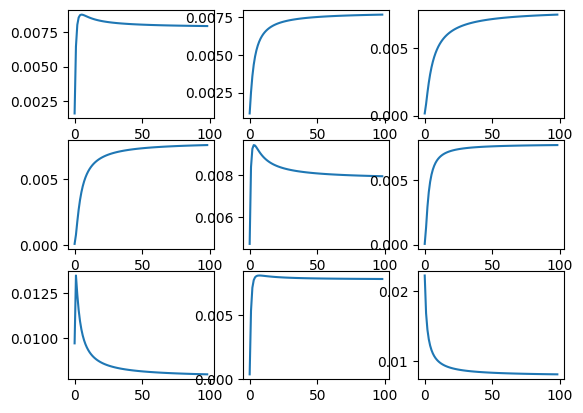

In [11]:
fig, axs = plt.subplots(3,3)
k=0
for i in range(3):
    for j in range(3):
        data_dict = ds[k]
        traj_t = data_dict["x"]
        #print(traj_t.sum(axis=1).shape)
        axs[i,j].plot(traj_t[:, np.random.choice(np.arange(traj_t.shape[1])), 0].squeeze())
        k+=1

## Train Model

### Setup dataloader

In [12]:
ds = BrownianMotionDataset(
    N=1000, include_D=False, seed=42,
    initial_condition=None, as_prob=True, channels_first=True,
    device=torch.device("mps")
)
data_dict = ds[0]
u_t = data_dict["x"]; u_t_1 = data_dict["y"]
u_t.device

device(type='mps', index=0)

In [13]:
dl = torch.utils.data.DataLoader(ds, batch_size=1, collate_fn=no_batching_fn)
data = next(iter(dl))
data["x"].device

device(type='mps', index=0)

### Setup logging

In [14]:
run = wandb.init(entity="aaprasad",
                 project="opLDS",
                 dir="./logs",
                 name="test_FNO_brownian_kl_v1",
                 notes="initial attempt at training fno on brownian motion using kl divergence",
                 )

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: aaprasad (talmolab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


### Initialize Model, trainer and optimizer

In [15]:
model = FNO(n_modes=(16,), in_channels=1, hidden_channels=16, out_channels=1,)

In [16]:
trainer = Trainer(model=model, n_epochs=100, device=torch.device("mps"), wandb_log=True, verbose=True)

In [17]:
optim = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ConstantLR(optim)

### Train Model

In [ ]:
trainer.train(dl, test_loaders={"test":dl}, eval_losses={"kl": KLDivergence(reduce="batchmean")}, optimizer=optim, scheduler=scheduler, training_loss=KLDivergence(reduction="batchmean"), save_best="test_kl", save_dir="../ckpt/fno1d_kl")

Training on 1000 samples
Testing on [1000] samples         on resolutions ['test'].


/Users/AadityaPrasad_1/miniforge3/envs/oplds/lib/python3.11/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Raw outputs of shape torch.Size([99, 1, 128])
[0] time=25.03, avg_loss=0.0001, train_err=0.0126


/Users/AadityaPrasad_1/miniforge3/envs/oplds/lib/python3.11/site-packages/torch/nn/functional.py:3384: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Eval: test_kl=0.0000
[Rank 0]: saved training state to ../ckpt/fno1d_kl
[1] time=24.09, avg_loss=0.0001, train_err=0.0098
Eval: test_kl=0.0000
[Rank 0]: saved training state to ../ckpt/fno1d_kl
[2] time=23.88, avg_loss=0.0000, train_err=0.0044
Eval: test_kl=0.0000
[Rank 0]: saved training state to ../ckpt/fno1d_kl
[3] time=24.36, avg_loss=0.0000, train_err=0.0031
Eval: test_kl=0.0000
[Rank 0]: saved training state to ../ckpt/fno1d_kl
[4] time=24.98, avg_loss=0.0000, train_err=0.0027
Eval: test_kl=0.0000
[Rank 0]: saved training state to ../ckpt/fno1d_kl
[5] time=24.30, avg_loss=0.0000, train_err=0.0015
Eval: test_kl=0.0000
[Rank 0]: saved training state to ../ckpt/fno1d_kl
[6] time=24.33, avg_loss=0.0000, train_err=0.0010
Eval: test_kl=0.0000
[Rank 0]: saved training state to ../ckpt/fno1d_kl
[7] time=24.33, avg_loss=0.0000, train_err=0.0009
Eval: test_kl=0.0000
[Rank 0]: saved training state to ../ckpt/fno1d_kl
[8] time=24.40, avg_loss=0.0000, train_err=0.0007
Eval: test_kl=0.0000
[Ra

## Investigate Model Results

### Visualize results at the end of training

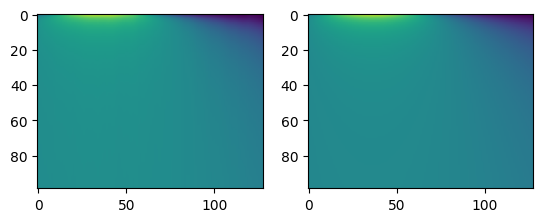

In [ ]:
_ = model.eval()
data = ds[0]
with torch.no_grad():
    preds = model(data["x"]).cpu().squeeze()
fig,axs = plt.subplots(1,2)
axs[0].imshow(preds)
axs[1].imshow(data["y"].squeeze().cpu().numpy())

### Visualize Best Model Predictions

tensor([[[0.0005, 0.0005, 0.0006,  ..., 0.0002, 0.0001, 0.0001]],

        [[0.0016, 0.0018, 0.0019,  ..., 0.0009, 0.0008, 0.0008]],

        [[0.0027, 0.0028, 0.0030,  ..., 0.0018, 0.0017, 0.0016]],

        ...,

        [[0.0076, 0.0076, 0.0076,  ..., 0.0075, 0.0074, 0.0074]],

        [[0.0076, 0.0076, 0.0076,  ..., 0.0075, 0.0074, 0.0074]],

        [[0.0076, 0.0076, 0.0076,  ..., 0.0075, 0.0074, 0.0074]]],
       device='mps:0')
tensor([[[0.0025, 0.0027, 0.0028,  ..., 0.0011, 0.0010, 0.0010]],

        [[0.0035, 0.0036, 0.0038,  ..., 0.0019, 0.0018, 0.0017]],

        [[0.0042, 0.0043, 0.0045,  ..., 0.0026, 0.0025, 0.0024]],

        ...,

        [[0.0076, 0.0076, 0.0076,  ..., 0.0074, 0.0074, 0.0074]],

        [[0.0076, 0.0076, 0.0076,  ..., 0.0074, 0.0074, 0.0074]],

        [[0.0076, 0.0076, 0.0076,  ..., 0.0074, 0.0074, 0.0074]]],
       device='mps:0')
tensor([[[1.9986e-05, 2.4250e-05, 2.9342e-05,  ..., 4.1503e-04,
          3.5810e-04, 3.0813e-04]],

        [[3.8984e-04,

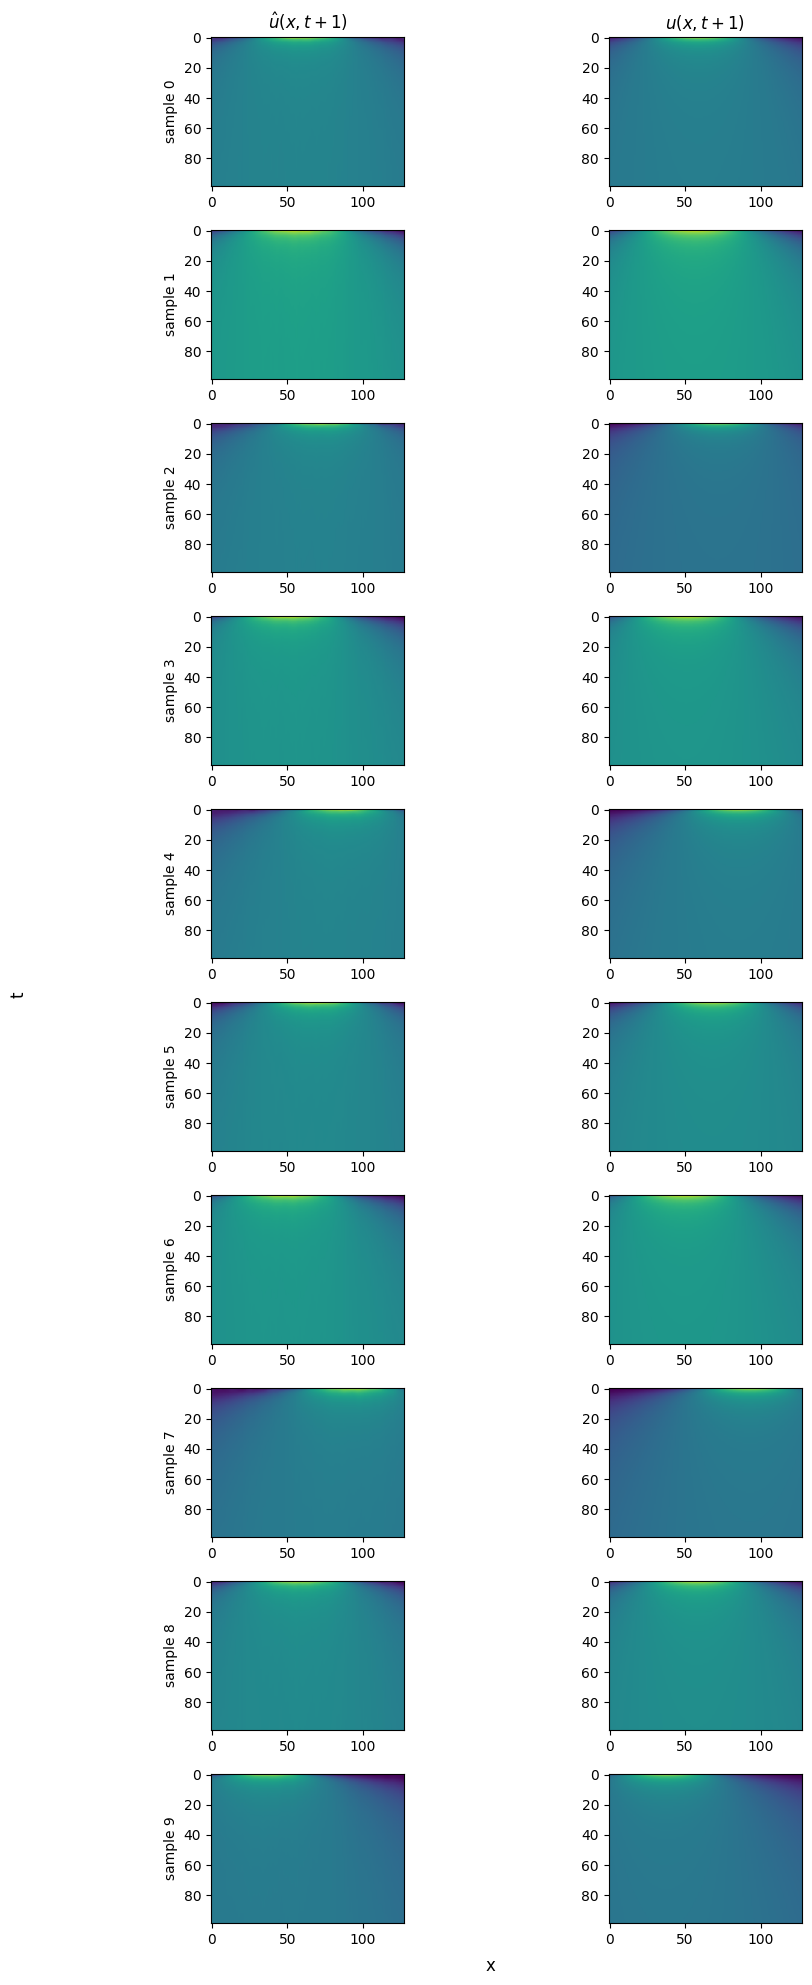

In [ ]:
fig,axs = plt.subplots(10,2, figsize=(10, 20))
model.load_state_dict(torch.load("../ckpt/best_model_state_dict.pt", weights_only=False))
_ = model.eval()
test_inds = np.random.choice(np.arange(len(ds)),size=10, replace=False)
for i,j in enumerate(test_inds):
    
    data = ds[int(j)]
    with torch.no_grad():
        preds = model(data["x"]).cpu().squeeze()

    axs[i, 0].imshow(preds)
    im = axs[i, 1].imshow(data["y"].squeeze().cpu().numpy())

    axs[i,0].set_ylabel(f"sample {i}")

axs[0,0].set_title(r"$\hat{u}(x,t+1)$")
axs[0,1].set_title(r"$u(x,t+1)$")
fig.supxlabel("x")
fig.supylabel("t")
# fig.colorbar(im)
fig.tight_layout()